# Домашнее задание 5

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 17 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_5

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{2}x^T A x - b^T x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица с $L =1000$, $\mu = 1$, $d = 100$, $b$ - так же случайный вектор.

__(а)__ Для такой задачи симулируем итерацию SGD:
$$
x^{k+1} = x^k - \gamma (\nabla f(x^k) + \xi^k),
$$
где $\xi^k$ - независимая от $x^k$ случайная величина из нормального распределения $\mathcal{N}(0, 100)$.

Для такого метода с $\gamma = \frac{1}{L}$ постройте график сходимости (критерий $\| \nabla f(x^k)\|^2$). Постройте на этом же графике сходимость честного градиентного спуска c $\gamma = \frac{1}{L}$. Сделайте вывод о характере сходимости нового метода.

In [21]:
import my_optimization as opt
import numpy as np

In [22]:
#optimization problem
args = {}
args['L'], args['mu'], args['d'] = 1000, 1, 100
args['A'] = opt.gen_A(args['d'], args['mu'], args['L'])
args['b'], x_0 = np.random.random_sample(args['d']), np.random.random_sample(args['d'])

In [23]:
n_iter = 10000
x, y, labels = [], [], []
n_iter_arr = [i for i in range(n_iter)]

ksi_sigma_list = [100, 10, 1, 0.1, 0.01, 0.001] #with sigma = 100 the convergence is bad, because the noise is high
def gamma_const(k, f, grad_f, x_k, x_true, args):
        return 1/args['L']
#noisy grad
for ksi_sigma in ksi_sigma_list:
   noisy_gd = opt.GradientOptimizer(opt.f_quad, opt.f_quad_grad, x_0 = x_0, criterium = '||grad_f(x_k)||', 
                                args = args, n_iter = n_iter, gamma_k = gamma_const, noisy_gradient_activate=True,
                                ksi_sigma=ksi_sigma)
   points_arr, differences_arr, times_arr, acc_arr = noisy_gd.descent()
   x.append(n_iter_arr)
   y.append(differences_arr)
   labels.append(r'noisy gradient, $\sigma = %f$' % ksi_sigma)

#gd

gd = opt.GradientOptimizer(opt.f_quad, opt.f_quad_grad, x_0 = x_0, criterium = '||grad_f(x_k)||', 
                                args = args, n_iter = n_iter, gamma_k = gamma_const)
points_arr, differences_arr, times_arr, acc_arr = gd.descent()
x.append(n_iter_arr)
y.append(differences_arr)
labels.append(r'GD')

100%|██████████| 10000/10000 [00:00<00:00, 35224.70it/s]


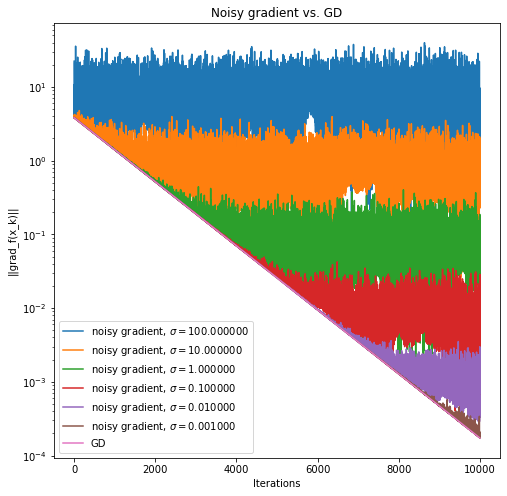

In [24]:
opt.plot_graphs(x, y, x_label = "Iterations", lines_labels = labels, title = 'Noisy gradient vs. GD', 
                        logscale = True, criteria_type = "||grad_f(x_k)||")

### Conclusion

The method convergence depends on $\sigma$, and in our setting if $x_0 \in [0;1]$ the less $\sigma$ the closer we to the GD, which is pretty obvious

__(б)__ На семинаре обсуждались способы борьбы со "стохастичностью" сходимости градиентного спуска. В частности, мы затронули использование уменьшающегося шага (смотри, например, Теорему 5 из [работы](https://arxiv.org/pdf/1907.04232.pdf)), а также использование батчирования (в нашем случае это просто замена: $\xi^k \to \frac{1}{b} \sum\limits_{i=1}^b \xi^k_i$, где $\xi^k_i \in \mathcal{N}(0, 100)$ и независимы). Реализуйте эти модификации (для батчирования возьмите $b = 10 , 100$). Добавьте полученные результаты на график сходимости из пункта (а). Постройте также график сходимости, где по оси $x$ будет не количество итераций, а количество генераций $\xi^k_i$ (количество вызовов стохастического градиента).

In [25]:
#Batching
n_iter = 10000
x, y, labels = [], [], []
n_iter_arr = [i for i in range(n_iter)]
ksi_sigma = 0.1
batch_size_list = [1, 10, 100]

#noisy grad
for batch_size in batch_size_list:
    noisy_gd = opt.GradientOptimizer(opt.f_quad, opt.f_quad_grad, x_0 = x_0, criterium = '||grad_f(x_k)||', 
                                        args = args, n_iter = n_iter, gamma_k = gamma_const, noisy_gradient_activate=True,
                                        ksi_sigma=ksi_sigma, batch_size = batch_size)
    points_arr, differences_arr, times_arr, acc_arr = noisy_gd.descent()
    x.append(n_iter_arr)
    y.append(differences_arr)
    labels.append(r'noisy gradient, $b = %i$' % batch_size)

100%|██████████| 10000/10000 [00:09<00:00, 1008.99it/s]


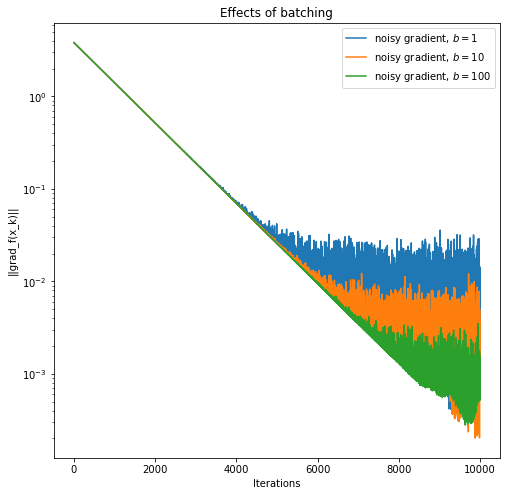

In [26]:
opt.plot_graphs(x, y, x_label = "Iterations", lines_labels = labels, title = 'Effects of batching', 
                logscale = True, criteria_type = "||grad_f(x_k)||")

In [27]:
#Decreasing gamma vs. Constant gamma
n_iter = 10000
x, y, labels = [], [], []
n_iter_arr = [i for i in range(n_iter)]
ksi_sigma = 0.1

noisy_gd = opt.GradientOptimizer(opt.f_quad, opt.f_quad_grad, x_0 = x_0, criterium = '||grad_f(x_k)||', 
                                args = args, n_iter = n_iter, gamma_k = gamma_const, noisy_gradient_activate=True,
                                ksi_sigma=ksi_sigma)
points_arr, differences_arr, times_arr, acc_arr = noisy_gd.descent()
x.append(n_iter_arr)
y.append(differences_arr)
labels.append(r'noisy gradient, $\gamma = const$')

args['a'] = args['L']

#implementation from Theorem 5
def gamma_decreasing(k, func, nabla_f, x_curr, x_sol, args):
    if n_iter <= args['d']/args['a']:
        return 1 / args['d']
    elif n_iter > args['d']/args['a'] and k < n_iter // 2:
        return 1 / args['a']
    else:
        t_0 = n_iter // 2
        kappa = 2 * args['d'] / args['a']
        return 2 / ((kappa + k - t_0) * args['a'])

noisy_gd_decr = opt.GradientOptimizer(opt.f_quad, opt.f_quad_grad, x_0 = x_0, criterium = '||grad_f(x_k)||', 
                                args = args, n_iter = n_iter, gamma_k = gamma_decreasing, noisy_gradient_activate=True,
                                ksi_sigma=ksi_sigma)
points_arr, differences_arr, times_arr, acc_arr = noisy_gd_decr.descent()
x.append(n_iter_arr)
y.append(differences_arr)
labels.append(r'noisy gradient, $decreasing \gamma$')

100%|██████████| 10000/10000 [00:00<00:00, 15720.75it/s]


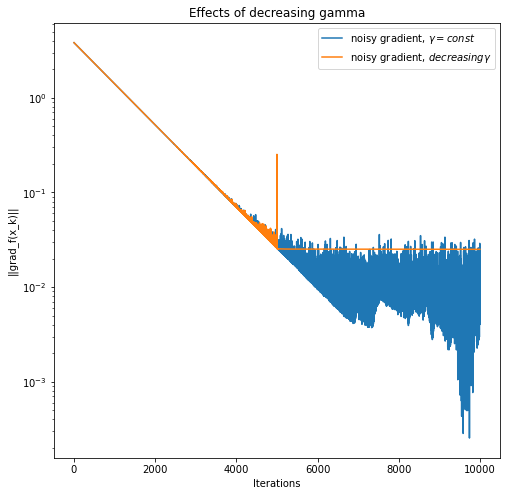

In [28]:
opt.plot_graphs(x, y, x_label = "Iterations", lines_labels = labels, title = 'Effects of decreasing gamma', 
                logscale = True, criteria_type = "||grad_f(x_k)||")

### Conclusion on batching and decreasing gamma

As we see both batching and decreasing gamma help to decrease the stochastic dynamics, but the criteria is not lower than it used to be. 

Batching helps a lot and the results significantly getting better with the increasing of batch_size, although the time also obviously increases approximately proportionally.

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). Как мы знаем, эта задача имеет вид конечной суммы:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{n} \sum\limits_{j=1}^n f_j(w) := \frac{1}{n} \sum\limits_{j=1}^n \left[\frac{1}{b} \sum\limits_{i=1}^b f_{ji}(w)\right] := \frac{1}{n} \sum\limits_{j=1}^n \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_i), y_i)\right],
\end{equation}
где $nb = N$ - полный размер выборки. Решите данную задачу с помощью SGD, SAGA (секция А.5 из [работы](https://arxiv.org/pdf/1905.11261.pdf)), SVRG (секция А.9 из [работы](https://arxiv.org/pdf/1905.11261.pdf)) и SARAH ([работа](https://arxiv.org/pdf/1703.00102.pdf)). 

__(а)__ Оцените $\mu$ и $L$ для данной задачи. Обратите внимание, что теория для SAGA, SVRG, SARAH предполагает, что $L$ - это константа Липшица градиентов $\nabla f_j$. 

Basically, the logistic regression loss function was in HW3, here we need to make some fixes for batching.

From HW3 we substitute $n$ on $b$, $i$ on $i + b(j - 1)$ to estimate the $\nabla f_j$, so it will look like:

$$\nabla_w f_j(w) = \nabla_w \frac1b \sum\limits_{i=1}^b \ln(1 + \exp(-w^Tx^{i + b(j - 1)} y_{i + b(j - 1)})) = 

\frac1b \sum\limits_{i=1}^b \frac{-x^{i + b(j - 1)} y_{i + b(j - 1)}\exp(-w^Tx^{i + b(j - 1)} y_{i + b(j - 1)})}{1 + \exp(-w^Tx^{i + b(j - 1)} y_{i + b(j - 1)})}$$

Also from HW3 we got:

$L = \| \frac14 X_n^TX_n \|$, so here it would be the following: $L_j = \| \frac14 X_{b(j - 1):bj}^TX_{b(j - 1):bj} \|$, therefore $L = \max_j(L_j)$

$\mu = 0$, because for $n = d = 1$ (which would be the same for higher dimensions) $\min f''(x) = \frac{a^2\exp(ax)}{(1 + \exp(ax))^2} = 0$ (https://math.stackexchange.com/questions/3149154/how-to-prove-the-logistic-loss-function-is-strongly-convex)

__(б)__ Реализуйте SGD, SAGA, SVRG, SARAH для задачи логистической регресии из $n$ слагаемых, где каждое слагаемое так же имеет виды суммы размеры $b$. Каким надо взять $b$? Почему? Что об этом говорит теория? Как будете выбирать шаг и другие параметры методов?

### Choice of parameters

$b$: I'll make an experiment for sgd with different batch sizer and after I'll choose one, though I think that $b$ = 100 will be okay.

$\gamma$ for each algorithm:

- SGD: $\gamma = \frac1{L}$ from the article, $\gamma_{k, th} = \frac1{k + 1}$ from the seminar
- SAGA: $\gamma = \frac{1}{6L}$, pg. 19 from https://arxiv.org/pdf/1905.11261.pdf
- SVRG: $\gamma = \frac{1}{6L}$, pg. 23, Corollary A.10 from https://arxiv.org/pdf/1905.11261.pdf
- SARAH: $\gamma = \frac1{2L}$ pg. https://arxiv.org/pdf/1703.00102.pdf

In [29]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

In [199]:
dataset = "mushrooms.txt" 
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2*y - 3
args = {}
args['X_train'], args['X_test'], args['y_train'], args['y_test'] = train_test_split(X, y, test_size=0.25, random_state=True)
n_all, args['d'] = args['X_train'].shape

x_0 = np.random.random_sample(args['d'])

args['b'] = 100
args['n'] = n_all // args['b']

L = 0
for j in range(args['n']):
    L_cur = np.linalg.norm(1/(4*args['n']) * args['X_train'][(j - 1)*args['b'] : j*args['b']].T @ args['X_train'][(j - 1)*args['b'] : j*args['b']])
    if L_cur > L:
        L = L_cur
args['L'] = L
print('L =', args['L'])

args['lambda'] = args['L'] / 1000

L = 4.6807080423561755


In [195]:
def logloss(w, args):
    ans = 0
    X = args['X_train']
    y = args["y_train"]
    for i in range(len(X)):
        ans += np.log(1 + np.exp(-(w @ X[i]) * y[i]))
    return ans / len(X)

def logloss_grad(w, args):
    X = args['X_train']
    y = args["y_train"]
    grad = np.zeros(w.size)
    n_samples = X.shape[0]
    for i in range(n_samples):
        grad += - X[i] * y[i] * np.exp(- w.dot(X[i]) * y[i]) / (1 + np.exp(- w.dot(X[i]) * y[i]))
    return grad / n_samples

def logloss_grad_j(w, j, args):
    X = args['X_train'][j * args['b'] : (j + 1) * args['b']]
    y = args["y_train"][j * args['b'] : (j + 1) * args['b']]
    grad = np.zeros(w.size)
    n_samples = X.shape[0]
    
    for i in range(n_samples):
        grad += - X[i] * y[i] * np.exp(- w.dot(X[i]) * y[i]) / (1 + np.exp(- w.dot(X[i]) * y[i]))
    return grad / n_samples

def log_acc(k, f, grad_f, x_k, x_true, args):
    corr_count = 0
    test_count = len(args['y_test'])
    for i in range(test_count):
        if args['X_test'][i].dot(x_k) * args['y_test'][i] > 0:
            corr_count += 1
    return corr_count / test_count

def l2_prox(x, k, args):
    gamma = gamma_const(None, None, None, None, None, args)
    alpha = np.max(1 - gamma * args['lambda'] / np.linalg.norm(x, ord=2), 0)

    return alpha * x

__(в)__ Постройте графики сравнения всех методов: по оси $x$ используйте время или количество подсчетов $\nabla f_{ji}$, по оси $y$ - $\|\nabla f(w^k)\|$ или точность на тесте. Таким образом, всего 4 графика. Сделайте сравнение и вывод.

In [244]:
#SGD
n_iter = 100
x, y, labels = [], [], []
n_iter_arr = [i for i in range(n_iter)]
def gamma(k, f, grad_f, x_k, x_true, args):
        return args['c']/args['L']
c_arr = [1, 10, 100]
b_arr = [10, 100]

for args['c'] in c_arr:
    for args['b'] in b_arr:
        sgd = opt.GradientOptimizer(logloss, logloss_grad, x_0 = x_0, criterium = '||grad_f(x_k)||', 
                                args = args, n_iter = n_iter, gamma_k = gamma, acc_k=log_acc, sgd_activate=True, 
                                grad_f_j=logloss_grad_j, prox_activate=True, prox_func=l2_prox)

        points_arr, differences_arr, times_arr, acc_arr = sgd.descent()
        x.append(n_iter_arr)
        y.append(differences_arr)
        labels.append(r'sgd, $\gamma = \frac{%f}{L}, b = %i$' % (args['c'], args['b']))
opt.plot_graphs(x, y, x_label = "Iterations", lines_labels = labels, title = 'SGD convergence', 
                logscale = True, criteria_type = "||grad_f(x_k)||")

100%|██████████| 100/100 [00:10<00:00,  9.76it/s]


100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


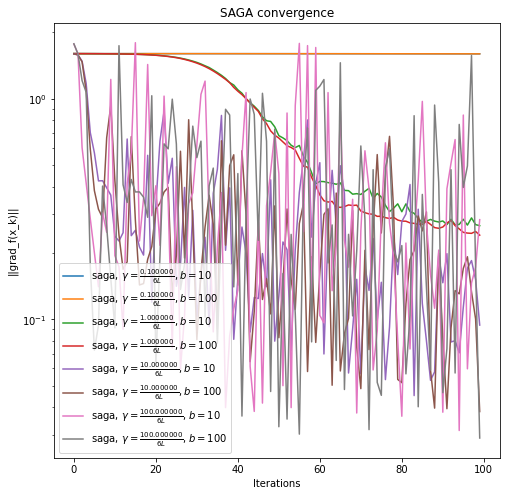

In [254]:
#SAGA
n_iter = 100
x, y, labels = [], [], []
n_iter_arr = [i for i in range(n_iter)]
def gamma(k, f, grad_f, x_k, x_true, args):
        return args['c']/(6*args['L'])

c_arr = [0.1, 1, 10, 100]
b_arr = [10, 100]

for args['c'] in c_arr:
    for args['b'] in b_arr:
        saga = opt.GradientOptimizer(logloss, logloss_grad, x_0 = x_0, criterium = '||grad_f(x_k)||', 
                        args = args, n_iter = n_iter, gamma_k = gamma, acc_k=log_acc, saga_activate=True, 
                        grad_f_j=logloss_grad_j, prox_activate=True, prox_func=l2_prox)

        points_arr, differences_arr, times_arr, acc_arr = saga.descent()
        x.append(n_iter_arr)
        y.append(differences_arr)
        labels.append(r'saga, $\gamma = \frac{%f}{6L}, b = %i$' % (args['c'], args['b']))
opt.plot_graphs(x, y, x_label = "Iterations", lines_labels = labels, title = 'SAGA convergence', 
                logscale = True, criteria_type = "||grad_f(x_k)||")

100%|██████████| 100/100 [00:10<00:00,  9.70it/s]


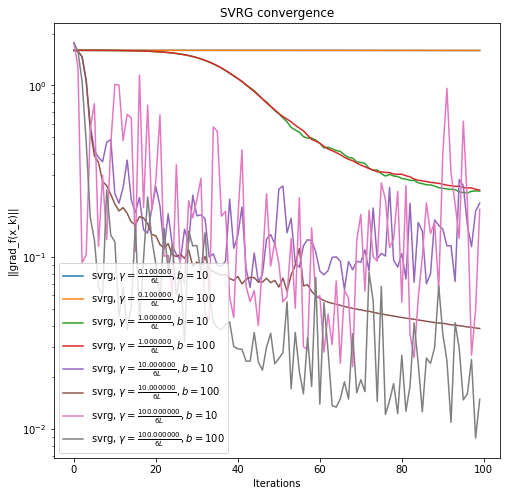

In [256]:
#SVRG
n_iter = 100
x, y, labels = [], [], []
n_iter_arr = [i for i in range(n_iter)]
def gamma(k, f, grad_f, x_k, x_true, args):
        return args['c']/(6*args['L'])

c_arr = [0.1, 1, 10, 100]
b_arr = [10, 100]

for args['c'] in c_arr:
    for args['b'] in b_arr:
        svrg = opt.GradientOptimizer(logloss, logloss_grad, x_0 = x_0, criterium = '||grad_f(x_k)||', 
                        args = args, n_iter = n_iter, gamma_k = gamma, acc_k=log_acc, svrg_activate=True, p_svrg=p_svrg, 
                        grad_f_j=logloss_grad_j, prox_activate=True, prox_func=l2_prox)

        points_arr, differences_arr, times_arr, acc_arr = svrg.descent()
        x.append(n_iter_arr)
        y.append(differences_arr)
        labels.append(r'svrg, $\gamma = \frac{%f}{6L}, b = %i$' % (args['c'], args['b']))
opt.plot_graphs(x, y, x_label = "Iterations", lines_labels = labels, title = 'SVRG convergence', 
                logscale = True, criteria_type = "||grad_f(x_k)||")

100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


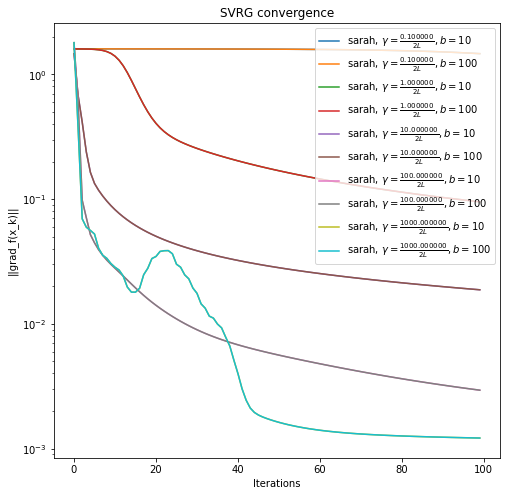

In [259]:
#SARAH
n_iter = 100
x, y, labels = [], [], []
n_iter_arr = [i for i in range(n_iter)]
def gamma(k, f, grad_f, x_k, x_true, args):
        return args['c']/(2*args['L'])

c_arr = [0.1, 1, 10, 100, 1000]
b_arr = [10, 100]

for args['c'] in c_arr:
    for args['b'] in b_arr:
        sarah = opt.GradientOptimizer(logloss, logloss_grad, x_0 = x_0, criterium = '||grad_f(x_k)||', 
                        args = args, n_iter = n_iter, gamma_k = gamma, acc_k=log_acc, sarah_activate=True, p_sarah=p_sarah, 
                        grad_f_j=logloss_grad_j, prox_activate=True, prox_func=l2_prox)

        points_arr, differences_arr, times_arr, acc_arr = sarah.descent()
        x.append(n_iter_arr)
        y.append(differences_arr)
        labels.append(r'sarah, $\gamma = \frac{%f}{2L}, b = %i$' % (args['c'], args['b']))
opt.plot_graphs(x, y, x_label = "Iterations", lines_labels = labels, title = 'SVRG convergence', 
                logscale = True, criteria_type = "||grad_f(x_k)||")

Here we see that SGD with $\gamma = \frac1L$ with $b = 100$, SAGA with SGD with $\gamma = \frac1{6L}$ with $b = 100$, SVRG with $\gamma = \frac{10}{6L}$ with $b = 100$, SARAH with $\gamma = \frac{100}{2L}$ with $b = 100$ are better and more stable, so let's choose $b = 100$ for all algorithms for unification, and also let's choose learning rate from the articles for all algorithms

### Training algorithms with these parameters

In [266]:
times_list, grad_call_list, differences_list, acc_list, labels_list = [], [], [], [], []
args['b'] = 100

In [267]:
#SGD
n_iter = 100

grad_calls_arr = [i for i in range(n_iter)]
def gamma(k, f, grad_f, x_k, x_true, args):
        return 1/args['L']

sgd = opt.GradientOptimizer(logloss, logloss_grad, x_0 = x_0, criterium = '||grad_f(x_k)||', 
                        args = args, n_iter = n_iter, gamma_k = gamma, acc_k=log_acc, sgd_activate=True, 
                        grad_f_j=logloss_grad_j, prox_activate=True, prox_func=l2_prox)

points_arr, differences_arr, times_arr, acc_arr = sgd.descent()
times_list.append(times_arr)
grad_call_list.append(grad_calls_arr)
differences_list.append(differences_arr)
acc_list.append(acc_arr)
labels_list.append(r'sgd, $\gamma = \frac{1}{L}$')

100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


In [268]:
#SAGA
n_iter = 100

grad_calls_arr = [(2 + args['n'])*i for i in range(n_iter)]
def gamma(k, f, grad_f, x_k, x_true, args):
        return 1/(6*args['L'])

saga = opt.GradientOptimizer(logloss, logloss_grad, x_0 = x_0, criterium = '||grad_f(x_k)||', 
                        args = args, n_iter = n_iter, gamma_k = gamma, acc_k=log_acc, saga_activate=True, 
                        grad_f_j=logloss_grad_j, prox_activate=True, prox_func=l2_prox)

points_arr, differences_arr, times_arr, acc_arr = saga.descent()
times_list.append(times_arr)
grad_call_list.append(grad_calls_arr)
differences_list.append(differences_arr)
acc_list.append(acc_arr)
labels_list.append(r'saga, $\gamma = \frac{1}{6L}$')

100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


In [269]:
#SVRG
n_iter = 100
p_svrg = 0.5
grad_calls_arr = [(2 + args['n'] * p_svrg)*i for i in range(n_iter)]
def gamma(k, f, grad_f, x_k, x_true, args):
        return 10/(6*args['L'])

svrg = opt.GradientOptimizer(logloss, logloss_grad, x_0 = x_0, criterium = '||grad_f(x_k)||', 
                        args = args, n_iter = n_iter, gamma_k = gamma, acc_k=log_acc, svrg_activate=True, p_svrg=p_svrg, 
                        grad_f_j=logloss_grad_j, prox_activate=True, prox_func=l2_prox)

points_arr, differences_arr, times_arr, acc_arr = svrg.descent()
times_list.append(times_arr)
grad_call_list.append(grad_calls_arr)
differences_list.append(differences_arr)
acc_list.append(acc_arr)
labels_list.append(r'svrg, $\gamma = \frac{10}{6L}$')

100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


In [270]:
#SARAH
n_iter = 100
p_sarah = 0.5
grad_calls_arr = [(2 * (1 - p_sarah) + args['n'] * p_sarah)*i for i in range(n_iter)]
def gamma(k, f, grad_f, x_k, x_true, args):
        return 100/(2*args['L'])

sarah = opt.GradientOptimizer(logloss, logloss_grad, x_0 = x_0, criterium = '||grad_f(x_k)||', 
                        args = args, n_iter = n_iter, gamma_k = gamma, acc_k=log_acc, sarah_activate=True, p_sarah=p_sarah, 
                        grad_f_j=logloss_grad_j, prox_activate=True, prox_func=l2_prox)

points_arr, differences_arr, times_arr, acc_arr = sarah.descent()
times_list.append(times_arr)
grad_call_list.append(grad_calls_arr)
differences_list.append(differences_arr)
acc_list.append(acc_arr)
labels_list.append(r'sarah, $\gamma = \frac{100}{2L}$')

100%|██████████| 100/100 [00:15<00:00,  6.54it/s]


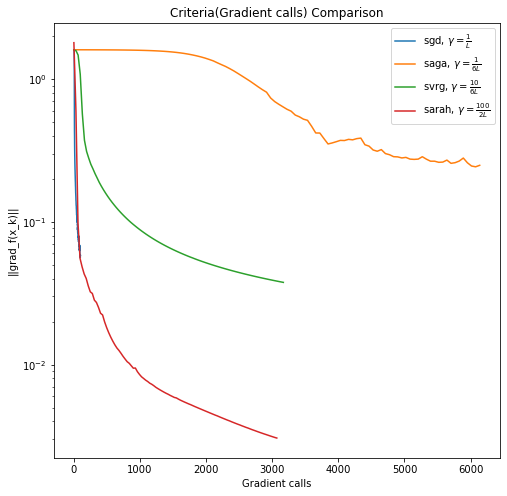

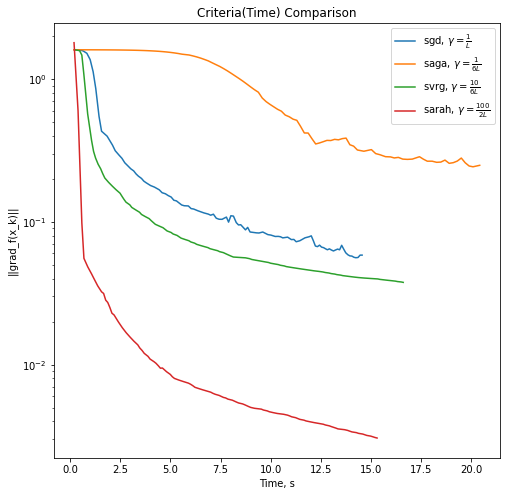

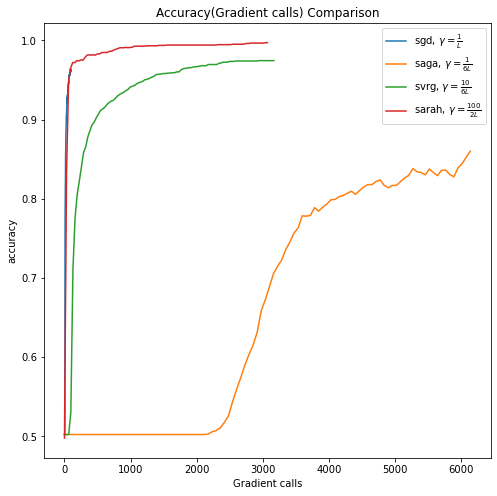

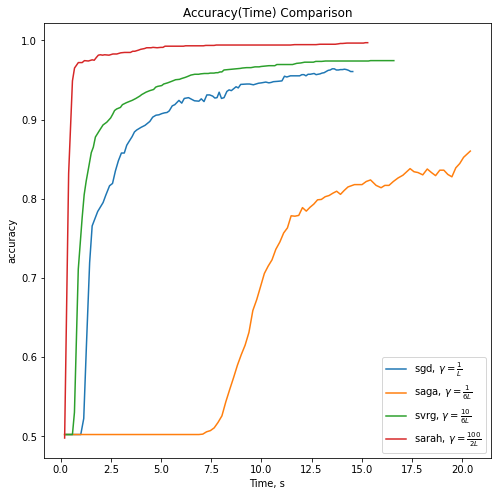

In [271]:
opt.plot_graphs(grad_call_list, differences_list, x_label = "Gradient calls", 
                lines_labels = labels_list, title = 'Criteria(Gradient calls) Comparison', logscale = True, 
                criteria_type = "||grad_f(x_k)||")

opt.plot_graphs(times_list, differences_list, x_label = "Time, s", 
                lines_labels = labels_list, title = 'Criteria(Time) Comparison', logscale = True, 
                criteria_type = "||grad_f(x_k)||")

opt.plot_graphs(grad_call_list, acc_list, x_label = "Gradient calls", 
                lines_labels = labels_list, title = 'Accuracy(Gradient calls) Comparison', logscale = False, 
                criteria_type = "accuracy")

opt.plot_graphs(times_list, acc_list, x_label = "Time, s", 
                lines_labels = labels_list, title = 'Accuracy(Time) Comparison', logscale = False, 
                criteria_type = "accuracy")

### Conclusion

- SGD: in terms of gradient calls it is one of the best methods (because it requires significantly less grad. calls), though in terms of time to converge it is one of the worst (because of the same reason)
- SAGA: came out to be the worst method for this problem in all metrics (maybe, not the best step was chosen, but I did choose it wisely)
- SVRG: in terms of time comparison it is the second best algorithm, but in terms of the gradient calls to converge it is one of the worst
- SARAH: came out to be the best method for this problem in all metrics, achieving high accuracy, good criteria in less gradient calls and less time needed.

__Бонусные пункты__

__(г)__ Методы SGD, SAGA, SVRG, SARAH, которые мы рассматривали, предполагают случайный выбор индекса на каждой итерации. Но между тем, на практике обычно делают по-другому и просто последовательно меняют $i_k$ от $1$ до $n$ (а потом заново). В [работе](https://arxiv.org/abs/2006.05988) изучаются такие подходы. Реализуйте Random Reshuffling и Shuffle Once для SGD и SARAH. Сравните новые алгоритмы со старыми версиями SGD и SARAH из пунктов (б) и (в).

In [ ]:
#ответ

__(д)__ Методы SVRG и SARAH имеют loopless версии: L-SVRG (секция А.10 из [работы](https://arxiv.org/pdf/1905.11261.pdf) и PAGE ([работа](https://proceedings.mlr.press/v139/li21a.html)), соотвественно. Реализуйте их. Как будете выбирать вероятности в этих алгоритмах? Сравните новые алгоритмы со старыми версиями SVRG и SARAH из пунктов (б) и (в).

In [ ]:
#ответ